# Data cleaning and preparation
Before jumping into the EDA (exploratory data analysis), we need to get our data cleaned and ready.

## Where is the data from?
This project uses data that has been scraped from Board Game Geek (https://boardgamegeek.com) and made available on Kaggle.

**Source** [Board Game Reviews - Jan 2025] https://www.kaggle.com/datasets/bwandowando/boardgamegeek-board-games-reviews-jan-2025 <br>
**Author Credit** [bwandowando] https://www.kaggle.com/bwandowando

**Source** [Baord Games Info from BGG] https://www.kaggle.com/datasets/fotopoulosvasileios/board-games-info-from-boardgamegeek-com?select=bg_designers.csv <br>
**Author Credit** [FOTOPOULOS VASILEIOS] https://www.kaggle.com/fotopoulosvasileios

## About the raw data
The raw data set consists of 3 CSV files with some of the fields shown below:
- boardgames.csv (Titles, Descriptions, Release Year, Ratings)
- boardgames_reviews.csv (Pseudo Users, Comments, Post Date, Rating)
- bg_info.csv (Age ratings, Complexity, Player Counts)
- my_local_bg_store.xlsx (List of games stocked by my local store)

---

# File 1 - boardgames.csv
The raw boardgames csv file initially looks like this:
![Raw_boardgames_file](../images/Raw_boardgames_file.png)

Before loading the raw data into Jupyter Notebooks, I completed some initial data cleaning of the boardgames.csv file in SQL.

## The SQL changes I made to this file are:
- Renamed column headers (more for personal preference, but it also helps me to remember what fields I have)
- Removed "link" and "thumbnail" as I don't currently need them

I then ran the below SQL code:
![boardgames_file_SQL_code](../images/boardgames_file_SQL_code.png)

Which can be copied below:

SELECT
	a."Rank",
	a."Game ID",
	a."Title",
	a."Description",
	a."Release Year",
	a."Geek Rating",
	a."Avg Rating",
	a."Voters"
FROM
	( 	SELECT 
			ROW_NUMBER () OVER ( PARTITION BY a."Game ID" ORDER BY a."Game ID" ) AS "Rn",
			a."Rank",
			a."Game ID",
			a."Title",
			a."Description",
			a."Year" AS "Release Year",
			a."Geek Rating",
			a."Avg Rating",
			a."Voters"	
		FROM 	
			dbo."BPP - Board Games" a
		WHERE 	
			a."Geek Rating" IS NOT NULL 
		AND 	
			a."Year" IS NOT NULL 		
		AND		
			a."Game ID" IS NOT NULL 				
		AND 	
			a."Rank" IS NOT NULL		
		AND
		 	a."Year" < 2024
	) a
WHERE a."Rn" = 1 
ORDER BY a."Rank"

## What does this do?
- The raw file consists of 161,404 "board games". I use quotes here as I would argue not every entry is actually a board game.
- Firstly, any game without a "Geek Rating" is removed. More details about the Geek Rating can be found on the "Understanding_Geek_Ratings" notebook. This reduces our list of games from 161,404 to 38,059.
- Some games do not have a release year. Perhaps no one knows when these games were released. Anyway, they were removed from the data set reducing the total by a further 276 to 37,783 games. Games without a release year included things like Go Fish and Poker Dice etc.
- Some games did not feature a "Game ID" or a "Rank". These were often game expansions and second editions. These were all excluded removing a further 10,943 leaving 26,840. That's still a lot of games! I decided to remove these from the initial analysis as I just want to determine the features of the original game to see if it is a classic. For a game to have a second edition or expansion, it must have garnered some level of success, which we could analyze later on. I also don't want the rating of the original game to be influenced by expansions or second editions... yet.
- Any duplicate "Game ID" were also removed, just in case. There were no duplicates, but seemed silly to remove the code which was doing no harm.
- Lastly, I removed any games released in 2024. This is because I want to work with only full years worth of data. This ensured every game on the list can contain at least one years worth of reviews etc. This removed another 1,045 games.

This leaves our starting pot of games at...
# 25,795

## Importing the cleaned board game data set
After performing the initial data cleaning in SQL, I exported the clean result to a CSV file called "Boardgames_SQL_Cleaned_File" and loaded it into the notebook using Python and pandas. 

To summarise, in the cleaned data set:
- Any duplicate game ID's have been removed
- The game must have a Geek Rating
- The game must have a Release Year
- The game must have an ID and a Rank
- The game must have been released before 2024

This data set will be used for further cleaning and feature engineering in this notebook. Below is an example of the first 10 rows of the SQL cleaned and formatted data so that we can see what we are working with.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the CSV file
df1 = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Show the top 10 rows
df1.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters
0,1,224517,Brass: Birmingham,"Build networks, grow industries, and navigate ...",2018,8.407,8.58,50109
1,2,161936,Pandemic Legacy: Season 1,Mutating diseases are spreading around the wor...,2015,8.370,8.52,54954
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624
3,4,174430,Gloomhaven,Vanquish monsters with strategic cardplay. Ful...,2017,8.335,8.57,64071
4,5,233078,Twilight Imperium: Fourth Edition,"Build an intergalactic empire through trade, r...",2017,8.232,8.58,25359
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081
7,8,115746,War of the Ring: Second Edition,The Fellowship and the Free Peoples clash with...,2011,8.192,8.55,22685
8,9,187645,Star Wars: Rebellion,Strike from your hidden base as the Rebels—or ...,2016,8.169,8.42,33850
9,10,162886,Spirit Island,Island Spirits join forces using elemental pow...,2017,8.144,8.34,55560


## Checking for outliers
There are two fields in this table where it is important to check for outliers:
- Release Year, are there some really old games impacting results?
- Voters, are some games wildly more popular skewing results?

## Dealing with Release Year outliers
Let's create a box plot to visualise the problem:

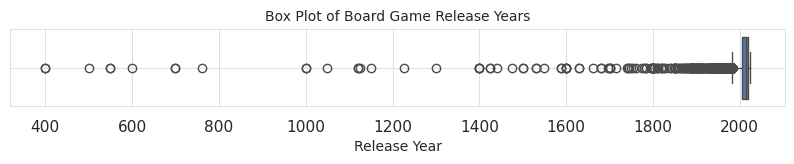

In [3]:
# Create a box plot of release years
sns.set(style="whitegrid")
plt.figure(figsize=(10, 1)) 
sns.boxplot(x=df1['Release Year'])

# Add title, formatting, and labels
plt.title('Box Plot of Board Game Release Years', fontsize=10)
plt.xlabel('Release Year', fontsize =10)
plt.grid(True, color='lightgrey', linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('lightgrey')
    spine.set_linewidth(0.5)

# Show plot
plt.show()

As you can see, we have some extreme outliers when it comes to board game release year. Some are over 1000 years old, and it is not likely gamers of the middle-ages were submitting board game reviews to BGG.com! Even if we take into account these 1000+ year old games, the average release year across all games is still 2007. We need to handle these outliers in a way that is fair and lessens the impact on our overall analysis.

Let's take a look at some of these games:

In [4]:
# Sort by oldest release year
df1_sorted = df1.sort_values(by='Release Year', ascending=True)

# Show the top 10 rows
df1_sorted.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters
2991,3080,2932,Hnefatafl,Defenders protect the king from invaders!,400,5.983,6.67,1749
25782,27884,2136,Pachisi,Be the first to get all your pieces around the...,400,4.710,4.52,5800
15840,17148,13654,Yut Nori,A race to be the first to get your horses arou...,500,5.523,5.87,174
16857,18322,18011,Chaturanga,An ancient Indian chess predecessor.,550,5.518,6.00,117
6179,6413,28302,Oware,Sow and reap to harvest more than opponent does.,550,5.674,6.52,471
13790,14799,41247,Mia,A dice game of deception and probabilities.,600,5.533,5.92,217
4025,4156,2448,Kalah,Move your seeds strategically to capture your ...,700,5.836,5.99,7555
7744,8076,11929,Go-Moku,"Alternately placing stones on a grid, you try ...",700,5.616,5.98,786
1979,2026,2393,Xiangqi,Use cannons and more to defeat the enemy Gener...,762,6.216,7.10,2187
7547,7874,315,Bagh Chal,"Translated as ""tigers moving"", this abstract s...",1000,5.621,6.22,441


If we consider how popular a game is, it is not fair to compare poor Pachisi here (released around 400 AD) to something like Wingspan (released in 2019.)

![Pachisi](../images/Pachisi.png)
[Pachisi - Wikipedia] https://en.wikipedia.org/wiki/Pachisi

Pachisi has a BGG release year of 400, and according to the Wikipedia article, it could even be as early as 1100 BC! This presented a couple of issues when trying to assess the popularity of a board game.
- On the one hand, Pachisi has had, on average, 1,604 more years to gain traction than modern games.
- On the other hand, I want to measure sustained popularity by looking at the average number of votes received per year. This means, in this example, we would take Pachisi's 5,800 votes over 1,624 years giving us 3.57 votes per year since release. That's low, and hardly seems fair when the BGG website itself was only launched in January 2000, so prior to this, votes could not even be logged and measured in this analysis.

### So, what can we do about this?
The first thing to increase fairness across the board, is to adjust the release year of older games to at least be in line with the launch of BGG in January 2000. I then found that no reviews were posted on the website in the year 2000 and the earliest reviews started to appear in 2001. Therefore any game older than 2001 has had it's release year adjusted to 2001 for the purpose of the analysis.

After deciding on a minimum release year of 2001, let's create the "Adjusted Release Year" column. The below code adds a column called "Adjusted Release Year". It looks at the release year and if it was before 2001, it adjusts the release year to 2001. If the release year is 2001 or later, it retains the original release year:

In [5]:
# Create new column "Adjusted Release year"
df1['Adjusted Release Year'] = df1['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Sort by oldest release year
df1_sorted = df1.sort_values(by='Release Year', ascending=True)

# Show the top 10 rows
df1_sorted.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year
2991,3080,2932,Hnefatafl,Defenders protect the king from invaders!,400,5.983,6.67,1749,2001
25782,27884,2136,Pachisi,Be the first to get all your pieces around the...,400,4.710,4.52,5800,2001
15840,17148,13654,Yut Nori,A race to be the first to get your horses arou...,500,5.523,5.87,174,2001
16857,18322,18011,Chaturanga,An ancient Indian chess predecessor.,550,5.518,6.00,117,2001
6179,6413,28302,Oware,Sow and reap to harvest more than opponent does.,550,5.674,6.52,471,2001
13790,14799,41247,Mia,A dice game of deception and probabilities.,600,5.533,5.92,217,2001
4025,4156,2448,Kalah,Move your seeds strategically to capture your ...,700,5.836,5.99,7555,2001
7744,8076,11929,Go-Moku,"Alternately placing stones on a grid, you try ...",700,5.616,5.98,786,2001
1979,2026,2393,Xiangqi,Use cannons and more to defeat the enemy Gener...,762,6.216,7.10,2187,2001
7547,7874,315,Bagh Chal,"Translated as ""tigers moving"", this abstract s...",1000,5.621,6.22,441,2001


Now we can see these older games have a release year of 2001.

If we then produce the same box plot on this "Adjusted Release Year" column we get this:

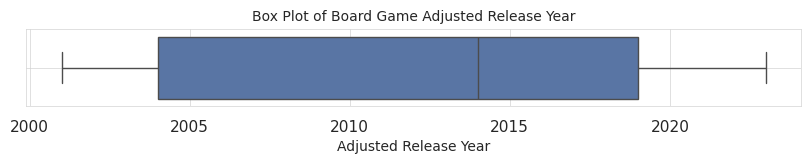

In [6]:
# Create a box plot of Adjusted Release Year
sns.set(style="whitegrid")
plt.figure(figsize=(10, 1)) 
sns.boxplot(x=df1['Adjusted Release Year'])

# Add title, formatting, and labels
plt.title('Box Plot of Board Game Adjusted Release Year', fontsize=10)
plt.xlabel('Adjusted Release Year', fontsize =10)
plt.grid(True, color='lightgrey', linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('lightgrey')
    spine.set_linewidth(0.5)

# Show plot
plt.show()

### Why this matters
This transformation forms an important step before we build our statistical analysis model. At the very least it improves visual clarity.
- It ensures modern (and the vast majority of) games are not compressed into a narrow range due to the skew from extreme values.
- It prevents misleading analysis from things like average values being adjusted significantly by the outlying data.
- It improves the readability of charts and summaries.
- It ensure any trend analysis is based on realistic and relevant data.

By adjusting the release year, we preserve the integrity of recent games whilst reducing the influence of abnormal records.

## Dealing with Voters outliers
A key measure I would like to use to measure a games success, is it's popularity. But how to we measure popularity? The simple method would be to use the total number of voters. However, that is not fair, and there are a few reasons for this.
- To determine if a game is truly popular, we need to see that it has a sustained popularity over time. Using just the total number of votes does not take this into consideration.
- As we have seen above, a games release year can have a significant impact on the number of votes a game will have received.
    - For example, **Wingspan** was released in 2019 and has **100,230** votes.
    - **CATAN** was released in 1995 and has **132,623** votes.
    - If we were to only consider the total number of votes, this would ensure that CATAN is the more popular game. However, Wingspan has **77%** of the total votes CATAN has received, and has only been available for **17%** of the lifespan of CATAN!
 
Seeing as we now have an "Adjusted Release Year", let's start by seeing how many votes each game received per year since its adjusted release date. We can go back to the above Wingspan vs CATAN example above to see how this works. I am going to exclude 2025 from the calculation as this will not contain a full years worth of votes.

The below code calculates the number of years since the "Adjusted Release Year" and populates it in a column called "Years Since Release" along with a check to make sure we don't divide by 0. It then divides the total votes received by the number of years since the adjusted release and rounds it to the nearest whole number.

In [7]:
# Calculate the number of years since the games adjusted release year
df1['Years Since Release'] = 2024 - df1['Adjusted Release Year']
df1['Years Since Release'] = df1['Years Since Release'].replace(0,1)

# Calculate votes per year rounded to nearest whole number
df1['Votes per Adjusted Release Year'] = df1['Voters'] / df1['Years Since Release']
df1['Votes per Adjusted Release Year'] = df1['Votes per Adjusted Release Year'].round(0).astype(int)

# Show the top 10 rows
df1.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year
0,1,224517,Brass: Birmingham,"Build networks, grow industries, and navigate ...",2018,8.407,8.58,50109,2018,6,8352
1,2,161936,Pandemic Legacy: Season 1,Mutating diseases are spreading around the wor...,2015,8.370,8.52,54954,2015,9,6106
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624,2021,3,16541
3,4,174430,Gloomhaven,Vanquish monsters with strategic cardplay. Ful...,2017,8.335,8.57,64071,2017,7,9153
4,5,233078,Twilight Imperium: Fourth Edition,"Build an intergalactic empire through trade, r...",2017,8.232,8.58,25359,2017,7,3623
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373,2020,4,12593
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081,2016,8,13010
7,8,115746,War of the Ring: Second Edition,The Fellowship and the Free Peoples clash with...,2011,8.192,8.55,22685,2011,13,1745
8,9,187645,Star Wars: Rebellion,Strike from your hidden base as the Rebels—or ...,2016,8.169,8.42,33850,2016,8,4231
9,10,162886,Spirit Island,Island Spirits join forces using elemental pow...,2017,8.144,8.34,55560,2017,7,7937


I also added the below filter just to see how this looks for our CATAN vs Wingspan example:

In [8]:
# Filter the results to only show rows where the Title is CATAN or Wingspan
filtered_df = df1[df1['Title'].isin(['CATAN', 'Wingspan'])]

# Show the top 2 rows of the filtered DataFrame
filtered_df.head(2)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year
31,32,266192,Wingspan,Attract a beautiful and diverse collection of ...,2019,7.879,8.03,100230,2019,5,20046
561,572,13,CATAN,Collect and trade resources to build up the is...,1995,6.915,7.09,132623,2001,23,5766


Wingspan appears to be 5x more popular than CATAN retaining 20k votes per year!

Now that we have a column calculating the votes per year for every game since it's adjusted release year, lets have a look and see if we have any outliers:

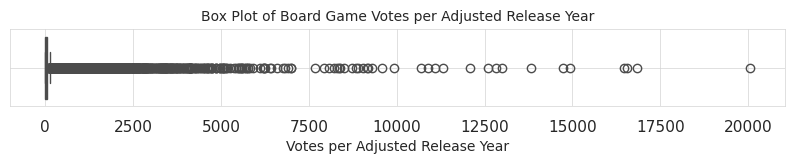

In [9]:
# Create a box plot of Votes per Adjusted Release Year
sns.set(style="whitegrid")
plt.figure(figsize=(10, 1)) 
sns.boxplot(x=df1['Votes per Adjusted Release Year'])

# Add title, formatting, and labels
plt.title('Box Plot of Board Game Votes per Adjusted Release Year', fontsize=10)
plt.xlabel('Votes per Adjusted Release Year', fontsize =10)
plt.grid(True, color='lightgrey', linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('lightgrey')
    spine.set_linewidth(0.5)

# Show plot
plt.show()

Yep. We got some outliers. And yes, the biggest outlier all the way to left there is Wingspan with its 20k votes per year.

![Wingspan](../images/Wingspan.png)

### So, what can we do about this distribution?
We need to adjust this in a way that is fair. We need to reduce the influence of these outliers, however, Wingspan still needs to come out on top, and rightfully so! 

To achieve this, I am going to use standard deviation to give us a **relative popularity score**. This will look at how far a games votes per year is from the mean, measured in standard deviations. Using this will not impact the overall popularity position of a game, but it will lessen the impact of individual votes received the further the total is away from the mean. 

The below code:
- Calculates the mean of the "Votes per Adjusted Year" column.
- Calculates the standard deviation of the "Votes per Adjusted Year" column.
- Adds a column called "SDs from Mean" which shows how many standard deviations the number of Votes per Adjusted Release Year is from the mean.
- Adds a column called "SD Weight" which means that smaller deviations from the mean will result in larger weights, and larger deviations will result in smaller weights.
- Adds a column called "Weighted Result" which multiples the Votes per Adjusted Release Year by the SD Weight. This result is then rounded to 2 decimal places.
- Adds a column called **"Popularity"** which normalises the Weighted Result on a scaled of **-1 to 1** rounded to 2 decimal places. Normalising the result will make comparisons easier later on.

In [10]:
# Calculate the standard deviation on Votes per Adjusted Release Year and apply it as a weighting column
mean_votes = df1['Votes per Adjusted Release Year'].mean()
std_dev_votes = df1['Votes per Adjusted Release Year'].std(ddof=0)
df1['SDs from Mean'] = (df1['Votes per Adjusted Release Year'] - mean_votes) / std_dev_votes
df1['SD Weight'] = 1 / ((df1['SDs from Mean'].abs() + 1))
df1['Weighted Result'] = df1['Votes per Adjusted Release Year'] * df1['SD Weight']
df1['Weighted Result'] = df1['Weighted Result'].round(2)

# Normalised results on a scale of -1 to 1 and name it Popularity
min_sd = df1['Weighted Result'].min()
max_sd = df1['Weighted Result'].max()
df1['Popularity'] = 2 * ((df1['Weighted Result'] - min_sd) / (max_sd - min_sd)) - 1
df1['Popularity'] = df1['Popularity'].round(2)

# Sort by most votes per adjusted release year
df_sorted2 = df1.sort_values(by='Votes per Adjusted Release Year', ascending=False)

# Show the top 5 rows
df_sorted2.head(5)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year,SDs from Mean,SD Weight,Weighted Result,Popularity
31,32,266192,Wingspan,Attract a beautiful and diverse collection of ...,2019,7.879,8.03,100230,2019,5,20046,33.254458,0.029193,585.21,1.00
191,197,350184,Earth,Strategically grow your ecosystem card engine ...,2023,7.356,7.65,16840,2023,1,16840,27.897978,0.034604,582.74,0.99
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624,2021,3,16541,27.398418,0.035213,582.46,0.99
39,40,373106,Sky Team,Pilot and co-pilot work together to land planes.,2023,7.815,8.18,16465,2023,1,16465,27.271440,0.035371,582.39,0.99
48,49,295947,Cascadia,Create the most harmonious ecosystem as you pu...,2021,7.758,7.93,44767,2021,3,14922,24.693446,0.038920,580.77,0.98


As you can see, Wingspan remains the most popular game with a normalised "Popularity" score of 1 (the highest achievable popularity score.)

Time for a new box plot showing the distribution of "Popularity" scores.

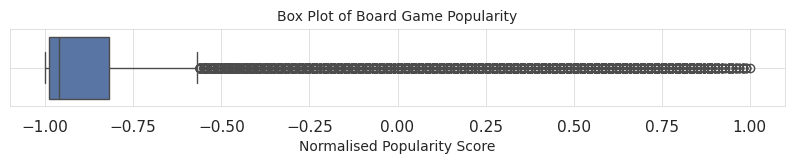

In [11]:
# Create a box plot of Popularity
sns.set(style="whitegrid")
plt.figure(figsize=(10, 1)) 
sns.boxplot(x=df1['Popularity'])

# Add title, formatting, and labels
plt.title('Box Plot of Board Game Popularity', fontsize=10)
plt.xlabel('Normalised Popularity Score', fontsize =10)
plt.grid(True, color='lightgrey', linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('lightgrey')
    spine.set_linewidth(0.5)

# Show plot
plt.show()

Even when using the weighted results, this tells us there are still some absolute giants when it comes to board game popularity. Most games never truly get off of the ground, but this makes it even more vital to determine, what make some of these games so wildly popular? How did they break away from the pack?

### To summarise popularity

#### We weighted the votes per year based on the distance from the mean
To better understand long-term popularity, we calculated the number of votes a game has received since its release. However, raw vote counts can be heavily skewed by a small number of extremely popular games. This makes it difficult to fairly compare games across the data set.

#### The problem
Games like **Wingspan** receive tens of thousands of votes per year. whilst most games receive much fewer than this. These high performers act as statistical outliers distorting the distribution and therefore dominate the popularity ranking system. 

#### The solution
We have applied a **custom weighting system** based on how far each game is from the average number of votes per year.
- Calculate distance from the mean in standard deviations
- Convert this distance into a weight
- Multiply the votes per year by the weight to give a weighted result
- Normalise the weighted result on a scale of -1 to 1 to give a "Popularity" score.

#### Why this matters
This technique reduces the influence of extreme outliers while still rewarding those consistently popular games. The order of the results is not changed. The more votes a game receives, lessens the influence of each vote allowing for fairer representation of overall games popularity. 

Just because one game is wildly popular, does not mean that games close behind are not also popular in the grand scheme of things. This result also values consistency over hype. Which is important when trying to determine if a game is "good". 

I want a way to demonstrate games with a sustained popularity, not just those with initial hype that quickly tailed off. To be able to determine if a game can reach a classic status, it needs to stand the test of time. 

## The Geek Rating
I have created a separate notebook explaining the Geek Rating called, "Understanding_Geek_Ratings". BGG's Geek Rating has, handily, already handled outliers affecting results as explained in the Understanding_Geek_Ratings section. So all we need to do here is normlise the Geek Rating on the same scale of -1 to 1.

Now that we know what a Geek Rating is and how it is calculated, I want to normalise the result so we can make better comparisons with a games Popularity. This will give us two powerful features to determine what makes a great game:
- Popularity - A measured of how many votes a game has received whilst accounting for outliers and sustained interest over the lifetime of the game.
- Quality - The Geek Rating normalised.

The below code normalises the Geek Rating and names it Quality. I also added a column called score which is just the Popularity and Quality results added together. This might be useful for ranking games objectively etc.

In [12]:
# Normalised Geek Rating on a scale of -1 to 1 and name it Quality
min_sd = df1['Geek Rating'].min()
max_sd = df1['Geek Rating'].max()
df1['Quality'] = 2 * ((df1['Geek Rating'] - min_sd) / (max_sd - min_sd)) - 1
df1['Quality'] = df1['Quality'].round(2)

# Add a column called score
df1['Score'] = df1['Popularity'] + df1['Quality']

# Show the top 10 rows
df1.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year,SDs from Mean,SD Weight,Weighted Result,Popularity,Quality,Score
0,1,224517,Brass: Birmingham,"Build networks, grow industries, and navigate ...",2018,8.407,8.58,50109,2018,6,8352,13.716504,0.067951,567.53,0.94,1.00,1.94
1,2,161936,Pandemic Legacy: Season 1,Mutating diseases are spreading around the wor...,2015,8.370,8.52,54954,2015,9,6106,9.963960,0.091208,556.92,0.90,0.98,1.88
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624,2021,3,16541,27.398418,0.035213,582.46,0.99,0.97,1.96
3,4,174430,Gloomhaven,Vanquish monsters with strategic cardplay. Ful...,2017,8.335,8.57,64071,2017,7,9153,15.054789,0.062287,570.11,0.95,0.97,1.92
4,5,233078,Twilight Imperium: Fourth Edition,"Build an intergalactic empire through trade, r...",2017,8.232,8.58,25359,2017,7,3623,5.815445,0.146726,531.59,0.82,0.92,1.74
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373,2020,4,12593,20.802229,0.045867,577.60,0.97,0.92,1.89
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081,2016,8,13010,21.498939,0.044447,578.25,0.98,0.91,1.89
7,8,115746,War of the Ring: Second Edition,The Fellowship and the Free Peoples clash with...,2011,8.192,8.55,22685,2011,13,1745,2.677744,0.271906,474.48,0.62,0.91,1.53
8,9,187645,Star Wars: Rebellion,Strike from your hidden base as the Rebels—or ...,2016,8.169,8.42,33850,2016,8,4231,6.831271,0.127693,540.27,0.85,0.90,1.75
9,10,162886,Spirit Island,Island Spirits join forces using elemental pow...,2017,8.144,8.34,55560,2017,7,7937,13.023136,0.071311,565.99,0.93,0.88,1.81


## Wrapping up the Boardgames file
Ultimately, we now have a tidy list of board games featuring:
- A filtered list of games
- A Popularity score for each game
- A Quality score for each game

Below is a tidy view of what we have created:

In [13]:
# Show the top 10 rows
df1[['Title', 'Popularity', 'Quality']].head(10)

,Title,Popularity,Quality
0,Brass: Birmingham,0.94,1.00
1,Pandemic Legacy: Season 1,0.90,0.98
2,Ark Nova,0.99,0.97
3,Gloomhaven,0.95,0.97
4,Twilight Imperium: Fourth Edition,0.82,0.92
5,Dune: Imperium,0.97,0.92
6,Terraforming Mars,0.98,0.91
7,War of the Ring: Second Edition,0.62,0.91
8,Star Wars: Rebellion,0.85,0.90
9,Spirit Island,0.93,0.88


---

# File 2 - boardgames_reviews.csv

The raw boardgames reviews file looks like this:

![Raw_boardgames_reviews_file](../images/Raw_boardgames_reviews_file.png)

And it is a big file. 29,618,236 rows to be exact. This consists of every review and vote cast for every board game on the website. 

![SQL_boardgame_review_count_query](../images/SQL_boardgame_review_count_query.png)

![SQL_boardgame_review_count_result](../images/SQL_boardgame_review_count_result.png)

Due to the sheer volume of reviews in the file, I wanted to display this data slightly differently using some grouping. Following this, I also had a think about how I could utilise the volume of votes and reviews data which lead me in my next great direction.

## How many votes does a game receive over time?
- Answering this question would allow me to factor in a games longevity, or sustained popularity.
- It will also allow us to see where games have been impacted by the "hype train".

## The SQL changes I made to this file are:
- Renamed the column headers
- There were some duplicated date/timestamp columns so I removed any I did not need and adjusted the formatting.

I then ran this SQL code:

![boardgame_reviews_SQL_code](../images/boardgame_reviews_SQL_code.png)

Which can be copied below:

SELECT 
    a."Game ID",
	b."Title",
	b."Year" AS "Release Year",
	CASE WHEN b."Year" < 2001 THEN 2001 ELSE b."Year" END AS "Adjusted Release Year", 
--    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2000 THEN 1 ELSE 0 END) AS [2000],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2001 THEN 1 ELSE 0 END) AS [2001],	
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2002 THEN 1 ELSE 0 END) AS [2002],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2003 THEN 1 ELSE 0 END) AS [2003],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2004 THEN 1 ELSE 0 END) AS [2004],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2005 THEN 1 ELSE 0 END) AS [2005],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2006 THEN 1 ELSE 0 END) AS [2006],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2007 THEN 1 ELSE 0 END) AS [2007],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2008 THEN 1 ELSE 0 END) AS [2008],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2009 THEN 1 ELSE 0 END) AS [2009],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2010 THEN 1 ELSE 0 END) AS [2010],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2011 THEN 1 ELSE 0 END) AS [2011],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2012 THEN 1 ELSE 0 END) AS [2012],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2013 THEN 1 ELSE 0 END) AS [2013],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2014 THEN 1 ELSE 0 END) AS [2014],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2015 THEN 1 ELSE 0 END) AS [2015],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2016 THEN 1 ELSE 0 END) AS [2016],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2017 THEN 1 ELSE 0 END) AS [2017],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2018 THEN 1 ELSE 0 END) AS [2018],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2019 THEN 1 ELSE 0 END) AS [2019],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2020 THEN 1 ELSE 0 END) AS [2020],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2021 THEN 1 ELSE 0 END) AS [2021],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2022 THEN 1 ELSE 0 END) AS [2022],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2023 THEN 1 ELSE 0 END) AS [2023],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2024 THEN 1 ELSE 0 END) AS [2024]
--    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2025 THEN 1 ELSE 0 END) AS [2025]
FROM 
    dbo."BPP - Board Game Reviews" a
LEFT JOIN
	dbo."BPP - Board Games" b ON a."Game ID" = b."Game ID"
WHERE 		
			b."Geek Rating" IS NOT NULL 
	AND 	b."Year" IS NOT NULL 		
	AND		b."Game ID" IS NOT NULL 										
	AND 	b."Rank" IS NOT NULL		
	AND 	b."Year" < 2020
GROUP BY 
    a."Game ID",
	b."Title",
	b."Year"

## What does this do?
- Firstly, if a game was released before 2001, the release year is adjusted to 2001. I have explained my reasons for this above when cleaning the "boardgames.csv" file.
- The next section of the query looks at the adjusted release year and sums together all of the a games reviews received within that year.
- I excluded the year 2000 from the results as there were not actually any reviews logged during this year.
- I also excluded any reviews in the year 2025 as they do not contain a complete years worth of data and are not required for this part of the analysis.
- Lastly, I removed any game released after 2019. The reason for this is, I want to have at least 5 complete years worth of data for each game so we can more accurately gauge if a game had a drop off from initial hype. This is very difficult to determine with less years worth of data. We could potentially look at making "drop-off" predictions with newer games following the results of the initial analysis though.

Our cleaned data file gives us total reviews pot of...
# 20,822

You'll notice this is less than the 25,795 games from the board games file above. This is due to excluding the 4,973 games released 2020 to 2024.

## Another thing to consider for later:
I also want to factor in the popularity and use of the BGG website itself, not just the individual board games. If we look at Monopoly for example, we can see the reviews are steadily increasing from 2001 to 2007 after which the volume of reviews received starts to significantly increase, peaking in 2020 (pandemic related lock-down Monopoly plays possibly?) 

![Monopoly](../images/Monopoly.png)

[Monopoly - Wikipedia] https://en.wikipedia.org/wiki/Monopoly_(game)

Anyway, my point here is I think there are a few factors that could be at play which need further looking into:
- **1** - The popularity of board games as a whole and the BGG website. Even though people may have owned a game like Monopoly for an eternity (or 1935 at the earliest), could it be due to the rising popularity of the medium as a whole that people feel the desire to leave their thoughts on this timeless classic? Which brings me onto thought number 2.
- **2** - The nature under which people decide to leave a review in the first place. Most often this will be to say something is fantastic, or it is rubbish. It is more rare to see the mediocre scoring.

## Importing the cleaned reviews data set
After performing the data cleaning in SQL, I once again exported the clean result to a CSV file to load into the notebook using Python and pandas. 

Below is an example of the first 10 rows of the SQL cleaned and formatted review data:

In [14]:
# Load the CSV file
df3 = pd.read_csv('Boardgames_Reviews_SQL_Cleaned_File.csv') 

# Show the top 10 rows
df3.head(10)

,Game ID,Title,Release Year,Adjusted Release Year,2001,2002,2003,2004,2005,2006,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,7,Cathedral,1979,2001,22,29,93,86,127,162,...,161,188,165,163,143,153,159,147,157,137
1,9,El Caballero,1998,2001,20,34,67,62,80,93,...,65,48,53,47,35,45,33,38,36,53
2,14,Basari,1998,2001,9,12,54,73,100,122,...,51,53,57,54,48,61,44,40,39,46
3,15,Cosmic Encounter,1977,2001,47,82,200,206,270,294,...,111,131,125,96,93,98,90,81,82,52
4,17,Button Men,1999,2001,9,22,46,43,53,61,...,22,32,36,30,20,18,20,20,15,8
5,19,Wacky Wacky West,1991,2001,17,20,68,66,72,98,...,74,74,79,77,79,92,85,80,85,67
6,20,Full Metal Planète,1988,2001,3,14,20,14,28,26,...,31,30,29,39,42,32,23,27,29,28
7,21,Gateway to the Stars,1994,2001,0,2,2,3,2,3,...,0,1,0,2,1,1,0,0,2,1
8,23,Divine Right,1979,2001,3,10,25,23,44,36,...,15,22,21,22,29,24,22,13,16,68
9,24,Twilight Imperium,1997,2001,8,21,72,70,68,55,...,22,16,16,15,10,16,7,9,10,11


---

# File 3 - bg_info.csv
The raw bg_info file looks like this:

![Raw_bg_info_file](../images/Raw_bg_info_file.png)

There are 25,339 rows in the data. I decided to make the changes to this file in Excel as the volume is much more manageable. This file gives us our features on which we will build the statistical analysis.

## The changes I made to this file are:
- Removed not needed columns (Geek Rating, Avg Rating, Num of votes, Year) as already have these in the file 1 "boardgames.csv".
- Formatted and renamed columns.

# After Excel data cleaning

![bg_info_cleaned](../images/bg_info_cleaned.png)

And here is how the table looks once loaded into our notebook:

In [15]:
# Load the CSV file
df4 = pd.read_csv('Boardgame_Info_Cleaned_File.csv') 

# Show the top 10 rows
df4.head(10)

,Title,Price,Complexity,Min players,Max players,Min time (mins),Max time (mins),Age Rating,Type 1,Type 2
0,Brass: Birmingham,84.99,3.89,2.0,4.0,60.0,120.0,14.0,Strategy,NaN
1,Pandemic Legacy: Season 1,49.97,2.83,2.0,4.0,60.0,60.0,13.0,Strategy,Thematic
2,Gloomhaven,NaN,3.90,1.0,4.0,60.0,120.0,14.0,Strategy,Thematic
3,Ark Nova,58.99,3.74,1.0,4.0,90.0,150.0,14.0,Strategy,NaN
4,Twilight Imperium: Fourth Edition,126.49,4.31,3.0,6.0,240.0,480.0,14.0,Strategy,Thematic
5,Terraforming Mars,79.99,3.26,1.0,5.0,120.0,120.0,12.0,Strategy,NaN
6,Dune: Imperium,51.43,3.03,1.0,4.0,60.0,120.0,14.0,Strategy,NaN
7,Gloomhaven: Jaws of the Lion,36.97,3.64,1.0,4.0,30.0,120.0,14.0,Strategy,Thematic
8,War of the Ring: Second Edition,74.89,4.21,2.0,4.0,150.0,180.0,13.0,Thematic,Wargames
9,Star Wars: Rebellion,NaN,3.74,2.0,4.0,180.0,240.0,14.0,Thematic,NaN


## Have we got any outliers in these files:
Lets make some box plots and find out!

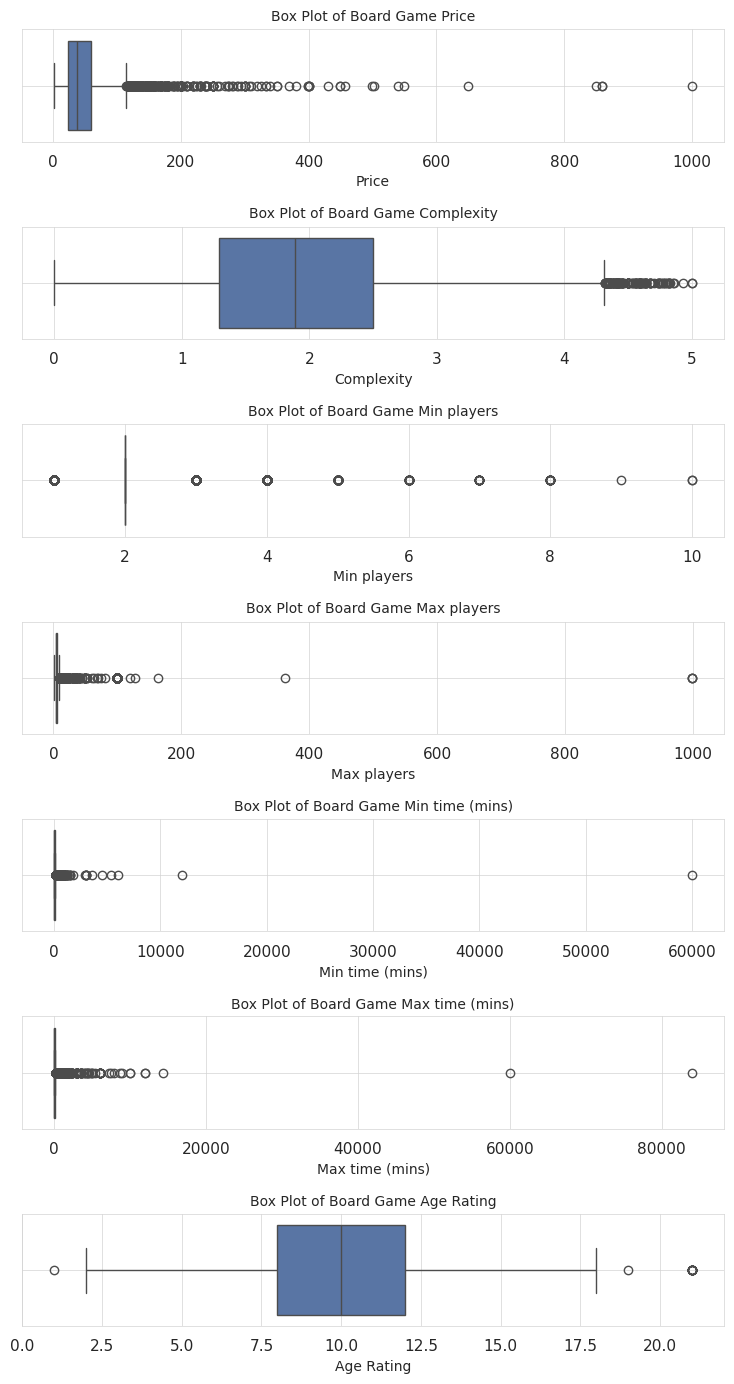

In [16]:
# Fields to plot
fields = ['Price', 'Complexity', 'Min players', 'Max players', 'Min time (mins)', 'Max time (mins)', 'Age Rating']

# Create subplots
fig, axes = plt.subplots(len(fields), 1, figsize=(7.5, len(fields) * 2))

# Loop through fields and create box plots
for i, field in enumerate(fields):
    sns.boxplot(ax=axes[i], x=df4[field])
    axes[i].set_title(f'Box Plot of Board Game {field}', fontsize=10)
    axes[i].set_xlabel(field, fontsize=10)
    axes[i].grid(True, color='lightgrey', linewidth=0.5)
    for spine in axes[i].spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(0.5)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Fields with outliers?
- **Price** - **Yes**, a few unusually expensive ones.
- Complexity - **No**, happy with this on it's scale of 1 to 5.
- Min Players - **No**, happy with the maximum being 10 here. Clearly the vast majority of games start at 2 players.
- **Max Players** - **Yes**. Some of these are interesting. A few games can have 999 players, but they will break if you have 1000 players. One game can have 362 players for some reason. I think it is fair to cap this at 100. I'm sure it's not common to find over 100 players for most play sessions.

![high_max_player_games](../images/high_max_player_games.png)

- **Min time (mins)** - **Yes**, if you want to get a game of "The Campaign for North Africa: The Desert War 1940-43" under your belt, apparently you are going to need 8 to 10 players with 42 consecutive sleepless days available.

![the_campaign_for_north_africa](../images/the_campaign_for_north_africa.png)

- **Max time (mins)** - **Yes**, similar reasons as above.
- Age Rating - **No**, happy with the range here.

### How shall we handle these fields?
For these fields:
- Price
- Max Players
- Min time
- Max time

I am going to use Winsorization. 

[Winsorization - Investopedia] https://www.investopedia.com/terms/w/winsorized_mean.asp

"The winsorized mean is an averaging method that replaces the smallest and largest values in a data set with the nearest observations to mitigate the influence of outliers."

I am going to apply this at the 99th percentile meaning any result over the 99th percentile is capped at the 99th percentile. My justification for this technique is that you could easily argue that no board game should:
- Cost over something like £500
- Require more than 20 players
- Take days to play

The below queries tell us what cap will be applied to each field:

In [17]:
df4['Price'].quantile(0.99)

272.41250000000105

In [18]:
df4['Max players'].quantile(0.99)

99.0

In [19]:
df4['Min time (mins)'].quantile(0.99)

360.0

In [20]:
df4['Max time (mins)'].quantile(0.99)

720.0

This tells us:
- The price will be capped at £272.41.
- The number of max players will be capped at 99.
- The min playtime is capped at 360 minutes.
- The max playtime is capped at 720 minutes.

The below code:
- Winsorizes the chosen columns
- Adds an upper and lower cap at the 99th percentile for each field
- Sorts by max player count to show values have been capped

This ensure the analysis is more robust and representative of a typical game.

In [21]:
# Fields to winsorize
columns_to_winsorize = ['Price', 'Max players', 'Min time (mins)', 'Max time (mins)']

# Calculate 99th percentile and Clip and cap the values
for col in columns_to_winsorize:
    upper_cap = df4[col].quantile(0.99)
    df4[col] = df4[col].clip(upper=upper_cap)
    df4[col] = df4[col].apply(lambda x: upper_cap if x > upper_cap else x)

# Sort to show high Max players at the top
df4.sort_values(by='Max players', ascending=False).head(10)

,Title,Price,Complexity,Min players,Max players,Min time (mins),Max time (mins),Age Rating,Type 1,Type 2
23681,Snowhere,NaN,1.00,1.0,99.0,20.0,20.0,8.0,NaN,NaN
4094,Floor Plan,14.86,1.77,1.0,99.0,20.0,40.0,8.0,Family,NaN
14317,Rory's Story Cubes: Doctor Who,NaN,1.00,1.0,99.0,10.0,10.0,10.0,NaN,NaN
21119,Cranium Junior,NaN,1.00,2.0,99.0,20.0,20.0,7.0,NaN,NaN
17146,Rory's Story Cubes: Adventure Time,NaN,1.00,1.0,99.0,10.0,10.0,6.0,NaN,NaN
11809,Paleontologists,NaN,1.67,1.0,99.0,15.0,20.0,8.0,NaN,NaN
17148,Rolling World,NaN,1.00,1.0,99.0,NaN,NaN,NaN,NaN,NaN
16848,Escape from the Museum,NaN,2.00,1.0,99.0,45.0,45.0,12.0,NaN,NaN
24537,"Marry, Date or Dump?",NaN,1.20,2.0,99.0,30.0,30.0,16.0,NaN,NaN
5973,Prawo Dżungli,NaN,1.36,2.0,99.0,10.0,10.0,8.0,Party,NaN


We can now recreate out box plots to see how the outliers have been handled:

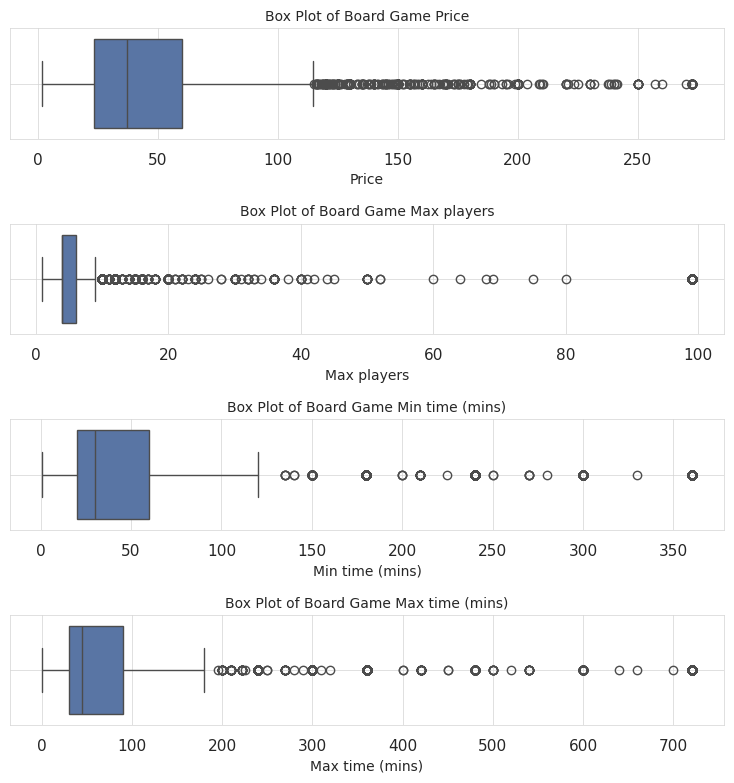

In [22]:
# Fields to plot
fields = ['Price', 'Max players', 'Min time (mins)', 'Max time (mins)']

# Create subplots
fig, axes = plt.subplots(len(fields), 1, figsize=(7.5, len(fields) * 2))

# Loop through fields and create box plots
for i, field in enumerate(fields):
    sns.boxplot(ax=axes[i], x=df4[field])
    axes[i].set_title(f'Box Plot of Board Game {field}', fontsize=10)
    axes[i].set_xlabel(field, fontsize=10)
    axes[i].grid(True, color='lightgrey', linewidth=0.5)
    for spine in axes[i].spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(0.5)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Much better!

Here is an example of the final cleaned table of board game information:

In [23]:
# Show the top 10 rows
df4.head(10)

,Title,Price,Complexity,Min players,Max players,Min time (mins),Max time (mins),Age Rating,Type 1,Type 2
0,Brass: Birmingham,84.99,3.89,2.0,4.0,60.0,120.0,14.0,Strategy,NaN
1,Pandemic Legacy: Season 1,49.97,2.83,2.0,4.0,60.0,60.0,13.0,Strategy,Thematic
2,Gloomhaven,NaN,3.90,1.0,4.0,60.0,120.0,14.0,Strategy,Thematic
3,Ark Nova,58.99,3.74,1.0,4.0,90.0,150.0,14.0,Strategy,NaN
4,Twilight Imperium: Fourth Edition,126.49,4.31,3.0,6.0,240.0,480.0,14.0,Strategy,Thematic
5,Terraforming Mars,79.99,3.26,1.0,5.0,120.0,120.0,12.0,Strategy,NaN
6,Dune: Imperium,51.43,3.03,1.0,4.0,60.0,120.0,14.0,Strategy,NaN
7,Gloomhaven: Jaws of the Lion,36.97,3.64,1.0,4.0,30.0,120.0,14.0,Strategy,Thematic
8,War of the Ring: Second Edition,74.89,4.21,2.0,4.0,150.0,180.0,13.0,Thematic,Wargames
9,Star Wars: Rebellion,NaN,3.74,2.0,4.0,180.0,240.0,14.0,Thematic,NaN


# File 4 - my_local_bg_store.xlsx
I sourced and compiled this data in Excel and Power Query. I connected to the below website for my data source:

(https://www.chanceandcounters.com/bristol-gloucester-road/games/)

I then used Power Query to clean and format the data into a list of titles currently stocked at the cafe:
![bg_store_powerquery](../images/bg_store_powerquery.png)

The resulting list of titles has been uploaded as a CSV file called My_Local_BG_Store_Cleaned_File.csv and looks like this:

In [24]:
# Load the CSV file
df5 = pd.read_csv('My_Local_BG_Store_Cleaned_File.csv') 

# Show the top 10 rows
df5.head(10)

,Title
0,13 Beavers
1,13 words
2,20 Second Showdown
3,3000 Scoundrels
4,6 Nimt
5,7 Wonders
6,7 Wonders Architects
7,7 Wonders Duel
8,A Fake Artist Goes to New York
9,A Game of Cat & Mouth
